# Office Hours - 06/14/21 

## OFFICE HOURS BOOKMARK

- [06/14/21 Office Hours](#06-14-21_office_hours)
    - Click above to jump to header.
    
___

# Topic 38: Time Series Models

- 06/02/21
- onl01-dtsc-ft-022221

## Learning Objectives:

- Introduce time series models.
- Discuss basic time series models/types (white noise, random walk)
- Learn about autocorrelation and seasonality. (PACF, ACF)
- Introduce ARMA/ARIMA and SARIMA models.
    - Deep dive into getting predictions/forecasts. 
- Activity: Modeling Baltimore Crime with statsmodels

## Questions

- Is it possible to run an AR(3,0) model and seeing that Lag 2 was insignificant run an AR model on Lag 1 and Lag 3 (essentially, can you exclude intermediary lags)
- What is the significance of the white noise and random walk models? 
    - Would we run them as 'dummy' models to compare performance of our AR models? Or are these types of time series that we could encounter in real data that can't really be modeled very well?
- Can you talk a little more about interpreting the ACF and PACF plots and how they can help us decide on the right parameters for AR and MA? The sarima lab has us do a grid search… why might we do that if selecting appropriate parameters can be done from looking at the ACF and PACF plots?
- Can you explain whether there is a mathematical reason to shifting/differencing and what they achieve? Shifting/differencing the time series seems a little arbitrary.
- Is it possible to overfit a time series model?


# Revisiting Baltimore Crime from Topic 37

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from random import gauss

pd.set_option('precision',3)
plt.rcParams['figure.figsize'] = [12,5]

## Plotly Express
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

## Statmodels time series analysis 
import statsmodels.tsa.api as tsa

In [ ]:
pwd

In [ ]:
## appending folder with functions
import sys
sys.path.append("../../topic_38_time_series_models/")

## Functions from Last Class 
%load_ext autoreload
%autoreload 2
import ts_functions as tsf

### Loading in Time Series

In [ ]:
## Load in file and parse_dates, check index
file ="https://raw.githubusercontent.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/master/Phase_4/topic_37_intro_to_time_series/baltimore_crime_counts_2021.csv"
df = pd.read_csv(file,parse_dates=True, index_col='CrimeDateTime')
display(df.head(),df.index)

> - If data is already in the frequency desired, can use `.resample("D").asfreq()` instead of an aggregation function

In [ ]:
## resample.asfreq
df = df.resample('D').asfreq()
df.index

In [ ]:
## Get a list of crimes to remind ourselves what we have
df.sum().sort_values(ascending=False)

In [ ]:
## Plot the weekly dataset to identify which ts to model
ax = df.plot(figsize=(12,8)) 
ax.legend(bbox_to_anchor=[1,1])

> For modeling purposes, we are going to focus on **Weekly crime** forecasts instead of daily, so we will resample to Weekly freq.

In [ ]:
## Lets resample the df to Weekly and save as new dfw
# also, let's take 2018 - present for ~3 years of data
dfw = df.resample('W').sum().loc['2017':]

In [ ]:
## Plot the weekly dataset to identify which ts to model
ax = dfw.plot(figsize=(12,8)) 
ax.legend(bbox_to_anchor=[1,1])

> #### Theres a lot of lines to sift through so lets use plotly express to make it easier


In [ ]:
# use px.line 
px.line(dfw)

- Before we dive into modeling crime, let's discuss the simplest time series models. 

# Basic Time Series models

## Simplest Time Series Models

- White Noise Model
- Random Walk Model

### White Noise Model
- 3 Properties:
    - Fixed and constant mean
    - Fixed and constant variance
    - No correlation over time

$$\Large Y_t =  \epsilon_t$$

The error term is randomly distributed around the mean, has constant variance, and no autocorrelation.

- Gaussian White Noise: A special case of a White Noise model is 
    - Mean is equal to zero
    - variance is equal to 1
    $$\large Y_t = \epsilon_t + \theta * \epsilon_{t-1}$$

In [ ]:
## White noise has mean=0, variance =1
mean = 0
variance = 1

## Make a white noise time series
noise = pd.Series([gauss(mean, np.sqrt(variance)) for x in range(1000)])
noise.plot(title='White Noise')

## Check our mean and variance
noise.mean(),noise.var()

#### Verify White Noise 

##### From 2015 scipy conference paper https://conference.scipy.org/proceedings/scipy2015/pdfs/margaret_mahan.pdf
- Use windows of 10% to asses white noise

In [ ]:
## Calc 10% of time steps/lags
window = round(len(noise)*.10)
window

In [ ]:
## Check if white noise
tsf.stationarity_check(noise, window=window)

### Random Walk Model
- Two Properties:
    - Has no specified mean or variance
    - Has a strong dependence over time

- Mathematically, this can be written as:

$$\large Y_t = Y_{t-1} + \epsilon_t$$

- Where $\epsilon_t$ is a *mean zero* white noise model

- Random Walk with a Drift":
    - a drift parameter $c$, steering in a certain direction.
$$\large Y_t = c + Y_{t-1} + \epsilon_t$$

In [ ]:
## Using white noise to simulate a random walk
#https://campus.datacamp.com/courses/time-series-analysis-in-python/some-simple-time-series?ex=7
walk = noise.shift(-1)+noise.cumsum()
walk.plot()

In [ ]:
## Check if random walk is stationary
tsf.stationarity_check(walk, window=window)

- When a random walk is differenced it returns a white noise. 

This is a result of the mathematical formula:

$$Y_t = Y_{t-1} + \epsilon_t$$
which is equivalent to
$$Y_t - Y_{t-1} = \epsilon_t$$

and we know that $\epsilon_t$ is a mean-zero white noise process! 

In [ ]:
## Confirm walk differenced returns a white noise
tsf.stationarity_check(walk.diff().dropna(),window=window)

## Finding Basic Time Series in Baltimore Crimes

### Identifying Crimes Optimal for Different Types of Times Series Models


- Using the plotly plot, explore individual crimes to identify which crimes are appropriate for the different types of time series models.
- Then confirm using stationarity check

- White Noise: ___
- Random Walk: ___

In [ ]:
## re-plot dfw and identify crimes that follow a white nosie or random walk model
px.line(dfw)

In [ ]:
### Identifying Crimes Optimal for Different Types of Times Series Models
ts_cols= {'white noise':dfw['HOMICIDE'],
         'random walk': dfw['LARCENY']}

### Check Our White Noise Crime

In [ ]:
## Calc 10% of time steps/lags
window = round(len(dfw)*.10)
window

In [ ]:
## Visualize white noise-like ts
tsf.stationarity_check(ts_cols['white noise'], window=window)

### Check Our Random Walk Crime

In [ ]:
## Visualize random-walk ts
## Visualize white noise-like ts
tsf.stationarity_check(ts_cols['random walk'], window=window)

In [ ]:
## Check if our random walk is stationary
tsf.stationarity_check(ts_cols['random walk'].diff().dropna(), window=window)

In [ ]:
## confirm our random walk becomes stationary white noise


# Correlation, Autocorrelation & Partial Autocorrelation

> Time Series that are correlated with themselves (autocorrelation) are best suited for a more complex modeling approach.

In [ ]:
## Use AGG. ASSAULT as ts 
crime = "AGG. ASSAULT"
ts = dfw[crime]
ts.plot()
plt.legend()

## Exploring Autocorrelation 

In [ ]:
## Save differenced version and plot
ts_diff = ts.diff().dropna()
ts_diff.plot()

In [ ]:
## Shift the ts_orig by -1 time lag
lag = -1
ts_shift = ts.shift(lag).dropna().rename(f"{lag}")

## Plot original ts vs shifted
ax = ts.plot()
ts_shift.plot(ax=ax)
ax.legend()


In [ ]:
pd.concat([ts,ts_shift],axis=1).corr()

In [ ]:
ts_diff = ts.diff().dropna()
ts_diff

In [ ]:
## Shift the orig ts from -1 to -52 lags

lags = list(range(-1,-53,-1))
shifted_ts = pd.concat([ts_diff.shift(lag).rename(f'{lag}') for lag in lags],axis=1)

shifted_ts.plot()

In [ ]:
ts_corrs = pd.concat([ts_diff,shifted_ts],axis=1).corr()
ts_corrs

In [ ]:
## Plot the correlations 

ts_corrs.loc['AGG. ASSAULT'].plot()

## ACF & PACF  Plots

### Autocorrelation Function Plots

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

> - "The **autocorrelation function** is a function that represents autocorrelation of a time series as a function of the time lag."
- The autocorrelation function tells interesting stories about trends and seasonality. For example, if the original time series repeats itself every five days, you would expect to see a spike in the autocorrelation function at 5 days.



In [ ]:
## Use panda's autocorrelation plot on the ts
pd.plotting.autocorrelation_plot(ts)

In [ ]:
## Use statsmodels ACF plot on ts
tsa.graphics.plot_acf(ts,lags=200);

In [ ]:
## Use plot_acf on ts_diff
tsa.graphics.plot_acf(ts_diff,lags=200);

### Partial-Autocorrelation Function Plot


> "The **partial autocorrelation function** can be interpreted as a regression of the series against its past lags.
 
 > It helps you come up with a possible order for the auto regressive term. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant. "

In [ ]:
## Use plot_pacf on ts
tsa.graphics.plot_pacf(ts,lags=52)

>- From Central Lecturer: gradual persistent autocorrelations in ACF indicate that differencing should be applied.

In [ ]:
## Use plot_pacf on ts_diff


### def  `plot_acf_pacf`

In [ ]:
def plot_acf_pacf(ts,figsize=(9,6),lags=52,suptitle=None,sup_y = 1.01):
    """Plot pacf and acf using statsmodels"""
    fig,axes=plt.subplots(nrows=2,figsize=figsize)
    
    tsa.graphics.plot_acf(ts,ax=axes[0],lags=lags);
    tsa.graphics.plot_pacf(ts,ax=axes[1],lags=lags);
    
    ## Add grid
    [ax.grid(axis='x',which='both') for ax in axes]
    
    if suptitle is not None:
        fig.suptitle(suptitle,y=sup_y,fontweight='bold',fontsize=15)
        
    fig.tight_layout()
    return fig,ax
    

In [ ]:
## Use function on original data
plot_acf_pacf(ts)

In [ ]:
## Use function on differenced data
plot_acf_pacf(ts_diff)

> When time series show autocorrelation, it is an indicator to use more complex time series models.

#  Time Series Modeling with `statsmodels`

## AR/MA MODELS

### Autoregressive Model (AR)



An autoregressive (AR) model is when a value from a time series is regressed on previous values from the same time series.

In words, the mathematical idea is the following:

$$ \text{Today = constant + slope} \times \text{yesterday + noise} $$

Or, mathematically:
$$\large Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$$

Some notes based on this formula:
- If the slope is 0, the time series is a white noise model with mean $\mu$
- If the slope is not 0, the time series is autocorrelated
- Bigger slope means bigger autocorrelation
- When there is a negative slope, the time series follows an oscillatory process


<!---

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-arma-models-online-ds-pt-100719/master/images/AR_model.png">

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-arma-models-online-ds-pt-100719/master/images/AR_PACF.png"> --->

In [ ]:
## Fit an AR model (using ARIMA with order (1,0,0))
model = tsa.arima.ARIMA(ts_diff, order=(1,0,0)).fit()
## Display mode. summary and plot diagnostics
display(model.summary())
model.plot_diagnostics();
plt.tight_layout()

In [ ]:
## funtionize diagnosing
def diagnose_model(model):
    """Takes a fit statsmodels model and displays the .summary 
    and plots the built-in plot.diagnostics()"""
    display(model.summary())
    model.plot_diagnostics();
    plt.tight_layout()

In [ ]:
## Repeat model and diagnose
ar1_model = tsa.arima.ARIMA(ts_diff, order=(1,0,0)).fit()
diagnose_model(ar1_model)

### The  Moving Average Model




The Moving Average model can be described as the weighted sum of today's and yesterday's noise.

In words, the mathematical idea is the following:

$$ \text{Today = Mean + Noise + Slope} \times \text{yesterday's noise} $$

Or, mathematically:
$$\large Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

Some notes based on this formula:
- If the slope is 0, the time series is a white noise model with mean $\mu$
- If the slope is not 0, the time series is autocorrelated and depends on the previous white noise process
- Bigger slope means bigger autocorrelation
- When there is a negative slope, the time series follow an oscillatory process


In [ ]:
## Fit a MA 1 ARIMA(0,0,1)
ma_model = tsa.arima.ARIMA(ts_diff, order=(0,0,1)).fit()
diagnose_model(ma_model)

### Which is performing better? (Use AIC)

In [ ]:
## can compare via the aic
print(f'AR1 Model aic = {ar1_model.aic:.3f}')
print(f'MA1 Model aic = {ma_model.aic:.3f}')

### Higher-order AR and MA models


- We are not limited to using just one time-step in our models. 
- The number of time steps used is called the **order** of the model.

#### First Order AR/MA Models:

- AR: $$Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$$
- MA: $$Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

#### Second-Order AR/MA Models

- AR(2): $$Y_t = \mu + \phi_1 * Y_{t-1}+\phi_2 * Y_{t-2}+\epsilon_t$$
- MA(2): $$Y_t = \mu +\epsilon_t + \theta_1 * \epsilon_{t-1}+ \theta_2 * \epsilon_{t-2}$$



#### Number of AR (Auto-Regressive) terms (`p`): 

- `p` is the auto-regressive part of the model. It indicates how many AR coefficients should be included based on `p` # of timesteps/lags.
    -  For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

#### Number of MA (Moving Average) terms (q): 

- `q` is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past.
    -  For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

### Create a New  AR/MA model (depending on AIC of previous models) using a higher order

In [ ]:
## Repeat model and diagnose
ma_model = tsa.arima.ARIMA(ts_diff, order=(0,0,2)).fit()
diagnose_model(ma_model)

#### Q: Did the model improve? What if we weren't limited to just AR or just MA?...

## ARMA & ARIMA Models

- We can combine BOTH an AR and MA model into one using an using an **AutoregRessive Moving Average** model (ARMA model).
    - We need to determine best number of p's and q's to use. 
- In actuality, we will go straight to using a slightly more advanced version of ARMA, which will actually difference our time series for us, allowing us to use the raw original ts for training. 
    

###  ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **AutoregRessive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.


>- **An ARIMA is specified with (`p`,`d`,`q`)**
    - Number of AR (Auto-Regressive) terms (p)
    - Number of Differences (`d`):
        - `d` is the **Integrated** component of an ARIMA model. The number of lag values to subtract from the current observation (aka differencing). 
    - Number of MA (Moving Average) terms ($q$)


In [ ]:
## Make an ARMA model with p=1, q=1
arma_model = tsa.arima.ARIMA(ts_diff, order=(1,0,1)).fit()
diagnose_model(arma_model)

## Determining the model and order to use via PACF/ACF _(if you can)_

- I've heard many different rules of thumb on how to use the PACF/ACF plots from earlier to determine whether to use AR/MA and how many p/q's to use. 
    - In my experience, it is rarely easy to see an obvious answer from these plots and it is better to use a gridsearch to determine the best performing model.
    - I have also heard competing answers on whether you should use the PACF/ACF for the original time series of the differenced time series.
    
- That all being said...

In [ ]:
## PLotting the original vs differenced timeseires
fig,axes = plt.subplots(nrows=2, figsize=(10,6))
ts.plot(ax=axes[0],title='Original/Raw TS')
ts_diff.plot(ax=axes[1],title='Differenced TS')
plt.tight_layout()

In [ ]:
## Plot raw time series PACF
plot_acf_pacf(ts)

In [ ]:
## Plotn differenced time sereis pacf
plot_acf_pacf(ts_diff)

#### Determining AR(p) and MA(q) using PACF [FROM  CANVAS]

- AR(p):
    - ACF for AR(p) would be strong until lag of p, then stagnant, then trail off. 
    - PACF for AR(p): Generally no correlation for lag values beyond p.
- MA(q):
    - ACF for MA(q) would show strong correlation up to a lag of q, the immedately delcine to minimal/no correction.
    - PACF would show strong relationship to the lag and tailing off to no correlation afterwards.
   
- Notation is generally ARMA(p,q)
- Example: ARMA(2,1) model equation
     $$Y_t = \mu + \phi_1 Y_{t-1}+\phi_2 Y_{t-2}+ \theta \epsilon_{t-1}+\epsilon_t$$

| Param| AR(p)   |   MA(q)  | ARMA(p,q)|
|------|------|------|------|
|   ACF | Tails off   |  Cuts off after lag q |  Tails off   |
|   PACF | Cuts off after lag p  |   Tails off  |  Tails off  |
  parameters and use for prediction

In [ ]:
## Visualize either figure to look for the above
# p=2,3
plot_acf_pacf(ts_diff)

####  Determining AR(p) and MA(q) using PACF [INFO FROM UDEMY]

- **USE ACF TO JUDGE IF MA OR AR COMPONENTS:**
    - If lag 1 is positive: AR
    - If lag 1 is negatige: MA
    
- **PACF is best for picking AR (p)**
- **ACF is best for picking MA(q)**
    - If sharp drop off at lag of k (k= point on x axis) means use an AR model of order k.
    - If slow gradual decline: use MA
    
    

#### Determining AR(p) and MA(q) using PACF [Centra Lecturer]

<img src="https://raw.githubusercontent.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/master/Phase_4/topic_37_intro_to_time_series/ds-time_series-main/img/armaguidelines.png" width=90%>

### Determining `p`,`d`,`q` programmatically

In [ ]:
### From SARIMA Models Lab
import itertools
from tqdm.notebook import trange
# Define the p, d and q parameters to take any value between 0 and 2
ps = list(range(0,4))
ds = list(range(0,2))
qs = list(range(0,3))

# Generate all different combinations of p, q and q triplets
pdq_list = list(itertools.product(ps,ds, qs))
pdq_list

In [ ]:
## Loop through pdq_list, make an ARIMA model
# save p,d,q and aic to a model_aic list
model_aics= [['p','d','q','aic']]

## Make Results into a df and sort by aic
for i in trange(len(pdq_list)):
    p,d,q = pdq_list[i]
    model = tsa.arima.ARIMA(ts,order=(p,d,q),enforce_invertibility=False).fit()
    model_aics.append([p,d,q,model.aic])
    print(f'For ({p},{d},{q}), aic = {model.aic:.3f}')

results = pd.DataFrame(model_aics[1:],columns=model_aics[0]).sort_values('aic')
results

In [ ]:
## Save best_params as a dict
best_params = results.iloc[0][['p','d','q']].to_dict()
best_params

In [ ]:
## Make a best_model using the best_params from our loop
best_model =tsa.arima.ARIMA(ts, order= tuple(best_params.values())).fit()
diagnose_model(best_model)

# Forecasts vs Predictions (`statsmodels`)

## Forecasts

`model.forecast()`/`model.get_forecast()` are designed for predictions **after the training data**. It needs the # of time steps in the future to forecast. 
- `model.forecast()` will return JUST the mean value for the forecast.


- `forecast = model.get_forecast()` will return a special `PredictionResultsWrapper` object that contains:
    - `forecast.conf_int()`: the lower and upper limits of the confidence indterval (as a dataframe).
        ` forecast.predicted_mean`: the mean value of the forecast (returned as a series)

In [ ]:
## forecast
best_model.forecast(steps=12)

In [ ]:
## get_forecast
forecast = best_model.get_forecast(steps=12)
forecast

In [ ]:
## Check out the pred's predicted_mean
forecast.predicted_mean

In [ ]:
## check out pred's conf_int
forecast.conf_int()

In [ ]:
## Get confidence intervals and predicted mean
forecast_df = forecast.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['forecast'] = forecast.predicted_mean
forecast_df

In [ ]:
### PLot forecast with confidence intervals
fig,ax = plt.subplots()
ts.loc['2020':].plot(ax=ax,label='original ts')
forecast_df['forecast'].plot(ax=ax)


ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'],
                forecast_df['Upper CI'],alpha=0.6)

ax.legend()

### Forecasting Functions

In [ ]:
def get_df_from_pred(forecast_or_pred,forecast_label='Forecast'):
    """Takes a PredictionResultsWrapper from statsmodels
    extracts the confidence intervals and predicted mean and returns in a df"""
    forecast_df = forecast_or_pred.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df[forecast_label] = forecast_or_pred.predicted_mean
    return forecast_df

def plot_forecast_from_df(forecast_df,ts_diff=None,orig_label='True Data',
                          forecast_label='Forecast',
                          last_n_lags=52,figsize=(10,4)):
    """Takes a forecast_df from get_df_from_pred and optionally 
    the training/original time series.
    
    Plots the original ts, the predicted mean and the 
    confidence invtervals (using fill between)"""
    fig,ax = plt.subplots(figsize=figsize)

    if ts_diff is not None:
        ts_diff.iloc[-last_n_lags:].plot(label='True Data')
        
   
    forecast_df['Forecast'].plot(ax=ax,label=forecast_label)
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], 
                    forecast_df['Upper CI'],color='g',alpha=0.3)
    ax.legend()
    ax.set(title=f'Forecasted {ts_diff.name}')
    return fig,ax

In [ ]:
## Combine getting a new model, forecast_df, and plotting
best_model =tsa.arima.ARIMA(ts, order= tuple(best_params.values())).fit()
diagnose_model(best_model)


forecast = best_model.get_forecast(steps=12)
forecast_df = get_df_from_pred(forecast)
plot_forecast_from_df(forecast_df, ts)

## Predictions

- `.predict/get_prediction` return a prediction for times within the original training period. (can also get into future)
    - Instead of the number of timesteps, predict needs the start and end dates for the forecast. `start=None, end=None,`
        - Note: if no times are provided, it will produce predictions for the entire training time series.

    
- Dynamic vs One-Step-Ahead Predictions:
    - Additionally, since predictions are during the same times as the actual data, we have the option to get dynamic/non-dynamic forecasts.
    - `dynamic=True`: will behave like a forecast where each step in time is predicted based on the previously predicted time. 
    - `dynamic=False`: will ONLY predict one step ahead in time, so the predictions for all data points were ONLY guessing 1 step ahead for each point. 

In [ ]:
## Get one-step-ahead preditions for the last 12 weeks of the dataset
one_step_ahead_mean = model.predict(start=-12, end=-1,dynamic=False)
one_step_ahead_mean

In [ ]:
## get_prediction from model
one_step_ahead_prediction = model.get_prediction(start=-12,end=-1,dynamic=False)
one_step_ahead_prediction

In [ ]:
## conf_int
one_step_ahead_prediction.conf_int()

In [ ]:
## Also contains the .predicted mean
one_step_ahead_prediction.predicted_mean

In [ ]:
## plot one step ahead forecasat
one_step_ahead_prediction = model.get_prediction(start=-12,end=-1,dynamic=False)
forecast_df = get_df_from_pred(one_step_ahead_prediction)
f,ax = plot_forecast_from_df(forecast_df,ts)
f.suptitle('One Step Ahead',y=1.02)

In [ ]:
## Using the above functions, get a dyanmic prediction and plot
one_step_ahead_prediction = model.get_prediction(start=-12,end=-1,dynamic=True)
forecast_df = get_df_from_pred(one_step_ahead_prediction)
f,ax = plot_forecast_from_df(forecast_df,ts)
f.suptitle('Dynamic Forecast',y=1.02);

> #### Q: What do we notice about the dynamic vs non-dynamic predictions?


___

# SARIMA & SARIMAX MODELS:


### SARIMA Models

- Seasonal ARIMA Models add a longer/larger seasonal ARIMA model combined with a non-seasonal ARIMA model.

* `(p, d, q)` are the non-seasonal parameters described above.
* `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. 
* The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

- Note: we will use the `SARIMAX` model from statsmodels, which allows for another variable (`X` aka exog) to be used in the modeling.

In [ ]:
## make sure have pdfq=best params
pdq = tuple(best_params.values())
pdq

In [ ]:
## Make a SARIMAZ model using best pdq from ARIMA.
sarimax_model = tsa.SARIMAX(ts,order=pdq,enforce_invertibility=False).fit()
diagnose_model(sarimax_model)

> **Q: Does the seasonal ARIMA with seasonal order= (0,0,0,0)look familiar?**

In [ ]:
## Copy the above code and replace the SARIMAX with .arima.ARIMA


## Selecting Seasonal Orders

- Figuring out the seasonal component can be tricky. 
- For one, we have to know the value for $s$, which is how many time steps should be considered a season. 
    - Use seasonal decompose to look for potential seasonality/$s$

In [ ]:
## use seasonal decompose and plot to look for s
decomp = tsa.seasonal_decompose(ts)
decomp.plot();

- Using the value for $m$ inferred above, try making a SARIMAX model 

In [ ]:
sarimax_model = tsa.SARIMAX(ts,order=pdq,
                            seasonal_order=(1,0,1,52), 
                            enforce_invertibility=False).fit()
diagnose_model(sarimax_model)

In [ ]:
## using all of our functions to train our model, get and plot forecast


### Functionize Entire  process

In [ ]:
def evaluate_model():
    pass

In [ ]:
## Test functionizing process


## `pmdarima.auto_arima`

- While we could construct another loop/grid and add a seasonal PDQ list to iterate through (see the SARIMAX Lab for example).
- There is a package called `pmdarima` which makes an auto-arima model for python (like there is for R)
    - http://alkaline-ml.com/pmdarima/

In [ ]:
# !pip install -U pmdarima
import pmdarima as pmd
# help(pmd.auto_arima)

In [ ]:
## Cut down ts to 2019-present (for time sake)
ts = ts.loc['2019':]
ts.plot()

In [ ]:
## Use auto_arima 
auto_model = pmd.auto_arima(ts,start_p=0,start_q=0,d=1,
                            max_p=4,max_q=4,
                            max_P=3,max_Q=3,
                            start_P=0,start_Q=0,
                            m=52,
                            verbose=2)
diagnose_model(auto_model)

In [ ]:
## Make a sarimax using params from auto_model
model = tsa.SARIMAX(ts,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='W').fit()

diagnose_model(model)

In [ ]:
diagnose_model(model)
forecast = model.get_forecast(steps=12)
forecast_df = get_df_from_pred(forecast)
plot_forecast_from_df(forecast_df,ts)

<a id='06-14-21_office_hours'></a>

# **📖 06/14/21 Office Hours:** Train-test-split and model validation


## Activity: Modeling with Crimes

- Using the examples we've made in this notebook:
    - Select a crime from our original df.
    - Create a train/test/ split.
    - Train/tune a model using the training data. 
    - Get the model's forecast for the test data's period. 
    - Plot the model's forecast vs actual test data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from random import gauss

pd.set_option('precision',3)
plt.rcParams['figure.figsize'] = [12,5]

## Plotly Express
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

## Statmodels time series analysis 
import statsmodels.tsa.api as tsa

# !pip install -U pmdarima
import pmdarima as pmd
# help(pmd.auto_arima)

In [2]:
# pwd

### Functions from Class

In [3]:
## appending folder with functions
import sys
sys.path.append("../../topic_38_time_series_models/")

## Functions from Last Class 
%load_ext autoreload
%autoreload 2
import ts_functions as tsf

In [4]:
## funtionize diagnosing
def diagnose_model(model):
    """Takes a fit statsmodels model and displays the .summary 
    and plots the built-in plot.diagnostics()"""
    display(model.summary())
    model.plot_diagnostics();
    plt.tight_layout()
    
    
def plot_acf_pacf(ts,figsize=(9,6),lags=52,suptitle=None,sup_y = 1.01):
    """Plot pacf and acf using statsmodels"""
    fig,axes=plt.subplots(nrows=2,figsize=figsize)
    
    tsa.graphics.plot_acf(ts,ax=axes[0],lags=lags);
    tsa.graphics.plot_pacf(ts,ax=axes[1],lags=lags);
    
    ## Add grid
    [ax.grid(axis='x',which='both') for ax in axes]
    
    if suptitle is not None:
        fig.suptitle(suptitle,y=sup_y,fontweight='bold',fontsize=15)
        
    fig.tight_layout()
    return fig,ax
    

### Loading in Time Series

In [5]:
## Load in file and parse_dates, check index
file ="https://raw.githubusercontent.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/master/Phase_4/topic_37_intro_to_time_series/baltimore_crime_counts_2021.csv"
df = pd.read_csv(file,parse_dates=True, index_col='CrimeDateTime')
display(df.head(),df.index)

HOMICIDE  AGG. ASSAULT  COMMON ASSAULT  LARCENY  \
CrimeDateTime                                                                
2014-01-01 00:00:00+00:00         2            22              19       34   
2014-01-02 00:00:00+00:00         3             6              23       26   
2014-01-03 00:00:00+00:00         1            11              17       16   
2014-01-04 00:00:00+00:00         0            14              23       23   
2014-01-05 00:00:00+00:00         0             9              22       19   

                           AUTO THEFT  ROBBERY - CARJACKING  BURGLARY  \
CrimeDateTime                                                           
2014-01-01 00:00:00+00:00           9                   0.0        20   
2014-01-02 00:00:00+00:00           7                   1.0        28   
2014-01-03 00:00:00+00:00           3                   0.0        13   
2014-01-04 00:00:00+00:00          14                   0.0        20   
2014-01-05 00:00:00+00:00          11                   2.0        14   

                           LARCENY FROM AUTO  ROBBERY - COMMERCIAL  SHOOTING  \
CrimeDateTime                                                                  
2014-01-01 00:00:00+00:00                 15                     2         2   
2014-01-02 00:00:00+00:00                 10                     1         0   
2014-01-03 00:00:00+00:00                  6                     1         1   
2014-01-04 00:00:00+00:00                 15                     1         0   
2014-01-05 00:00:00+00:00                 13                     0         2   

                           ROBBERY - RESIDENCE  ROBBERY - STREET  ARSON  RAPE  
CrimeDateTime                                                                  
2014-01-01 00:00:00+00:00                  1.0               8.0    0.0   5.0  
2014-01-02 00:00:00+00:00                  1.0               4.0    0.0   0.0  
2014-01-03 00:00:00+00:00                  1.0               2.0    0.0   0.0  
2014-01-04 00:00:00+00:00                  1.0               7.0    0.0   0.0  
2014-01-05 00:00:00+00:00                  1.0              10.0    0.0   1.0

DatetimeIndex(['2014-01-01 00:00:00+00:00', '2014-01-02 00:00:00+00:00',
               '2014-01-03 00:00:00+00:00', '2014-01-04 00:00:00+00:00',
               '2014-01-05 00:00:00+00:00', '2014-01-06 00:00:00+00:00',
               '2014-01-07 00:00:00+00:00', '2014-01-08 00:00:00+00:00',
               '2014-01-09 00:00:00+00:00', '2014-01-10 00:00:00+00:00',
               ...
               '2021-05-13 00:00:00+00:00', '2021-05-14 00:00:00+00:00',
               '2021-05-15 00:00:00+00:00', '2021-05-16 00:00:00+00:00',
               '2021-05-17 00:00:00+00:00', '2021-05-18 00:00:00+00:00',
               '2021-05-19 00:00:00+00:00', '2021-05-20 00:00:00+00:00',
               '2021-05-21 00:00:00+00:00', '2021-05-22 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='CrimeDateTime', length=2699, freq=None)

In [6]:
## resample.asfreq
dfw = df.resample('W').sum()#:]
dfw.index

DatetimeIndex(['2014-01-05 00:00:00+00:00', '2014-01-12 00:00:00+00:00',
               '2014-01-19 00:00:00+00:00', '2014-01-26 00:00:00+00:00',
               '2014-02-02 00:00:00+00:00', '2014-02-09 00:00:00+00:00',
               '2014-02-16 00:00:00+00:00', '2014-02-23 00:00:00+00:00',
               '2014-03-02 00:00:00+00:00', '2014-03-09 00:00:00+00:00',
               ...
               '2021-03-21 00:00:00+00:00', '2021-03-28 00:00:00+00:00',
               '2021-04-04 00:00:00+00:00', '2021-04-11 00:00:00+00:00',
               '2021-04-18 00:00:00+00:00', '2021-04-25 00:00:00+00:00',
               '2021-05-02 00:00:00+00:00', '2021-05-09 00:00:00+00:00',
               '2021-05-16 00:00:00+00:00', '2021-05-23 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='CrimeDateTime', length=386, freq='W-SUN')

In [7]:
## Get a list of crimes to remind ourselves what we have
dfw.sum().sort_values(ascending=False)

LARCENY                 74681.0
COMMON ASSAULT          57451.0
BURGLARY                46935.0
LARCENY FROM AUTO       43223.0
AGG. ASSAULT            38478.0
AUTO THEFT              29502.0
ROBBERY - STREET        23056.0
ROBBERY - COMMERCIAL     5872.0
SHOOTING                 4777.0
ROBBERY - RESIDENCE      3590.0
ROBBERY - CARJACKING     3128.0
HOMICIDE                 2311.0
RAPE                     2236.0
ARSON                    1409.0
dtype: float64

In [8]:
px.line(dfw,width=900)

<AxesSubplot:xlabel='CrimeDateTime'>

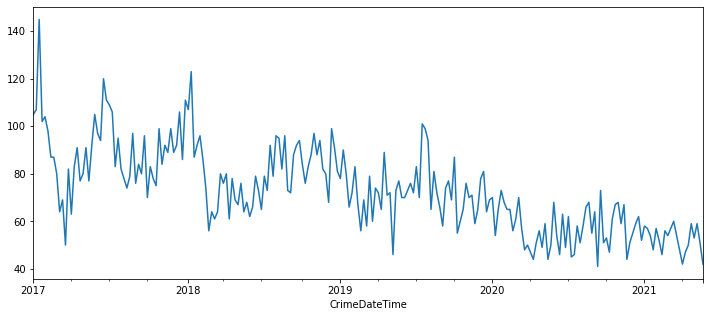

In [9]:
## save chosen ts as var
ts = dfw['AUTO THEFT'].loc['2017':].copy()
ts.plot()

### Train-Test-Split for Time Series

In [10]:
# get the tts_cutoff  (the # of timesteps/rows to split at)
tts_cutoff = round(ts.shape[0]*0.90)
tts_cutoff

207

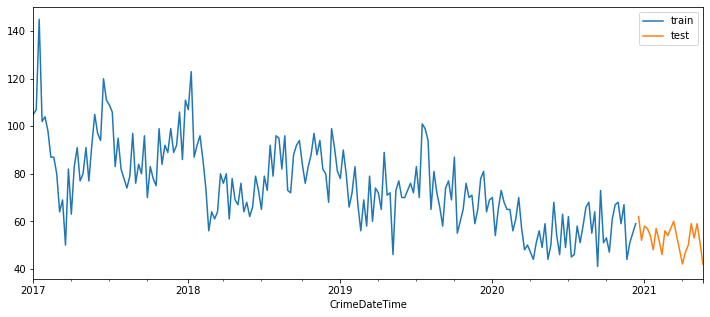

In [11]:
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

## Plot
ax = train.plot(label='train')
test.plot(label='test')
ax.legend()

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results          -3.409           3                     203   

                   p-value  p<.05  Stationary?  
AD Fuller Results    0.011   True         True

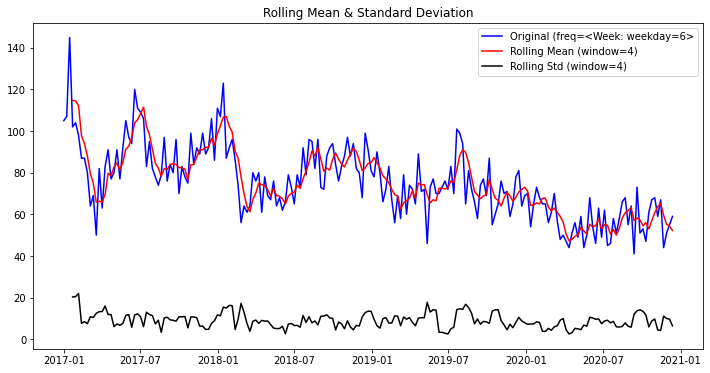

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results          -3.409           3                     203   

                   p-value  p<.05  Stationary?  
AD Fuller Results    0.011   True         True

In [12]:
## check staationarity 
tsf.stationarity_check(train, window=4)

(<Figure size 648x432 with 2 Axes>, <AxesSubplot:xlabel='CrimeDateTime'>)

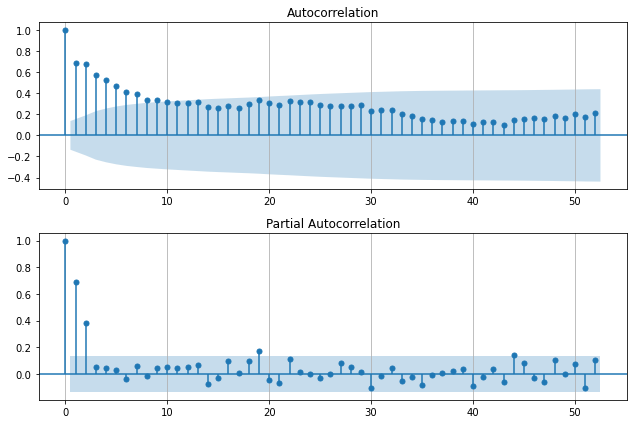

In [13]:
### Check PACF/ACF to infer p/q (if possible)
plot_acf_pacf(train)

(<Figure size 648x432 with 2 Axes>, <AxesSubplot:xlabel='CrimeDateTime'>)

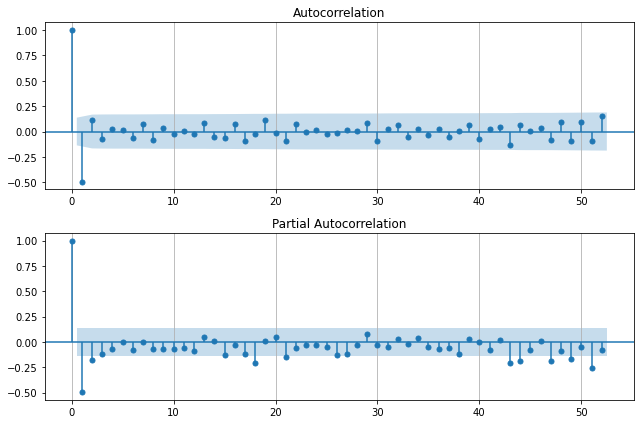

In [14]:
### Check PACF/ACF to infer p/q (if possible)
plot_acf_pacf(train.diff().dropna())

- Possible values:
    - p:
    - d:
    - q:

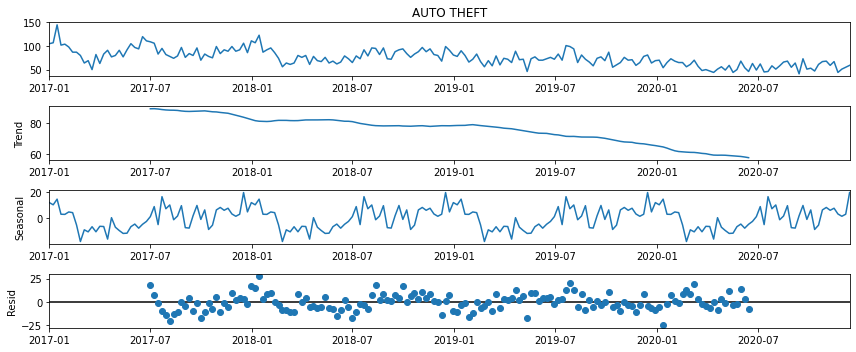

In [15]:
## Use Seasonal Decompose to check for seasonality 
decomp = tsa.seasonal_decompose(train)
decomp.plot();

>- **NOTE: I removed the use of any functions from the rest of the workflow** in order to make it more transparent as to what we are doing.
    - I HIGHLY recommend functionizing a lot of longer blocks of code that you will need to repeat for each model/zipcode/stock.

In [16]:
## Gridsearch params
auto_model = pmd.auto_arima(train,start_p=0,max_p=5,
                           start_q=0,max_q=5,d=1,m=52,
                           start_P=0,start_Q=0,verbose=True)
display(auto_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  207
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -790.417
Date:                             Mon, 14 Jun 2021   AIC                           1586.834
Time:                                     13:18:30   BIC                           1596.818
Sample:                                          0   HQIC                          1590.872
                                             - 207                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5944      0.053    -11.278      0.000      -0.698      -0.491
ar.S.L52       0.2376      0.077      3.081      0.002       0.086       0.389
sigma2       123.8754     12.568      9.857      0.000      99.243     148.508
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.61   Prob(JB):                         0.93
Heteroskedasticity (H):               0.56   Skew:                             0.06
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          AUTO THEFT   No. Observations:                  207
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -790.417
Date:                             Mon, 14 Jun 2021   AIC                           1586.834
Time:                                     13:18:31   BIC                           1596.818
Sample:                                 01-01-2017   HQIC                          1590.872
                                      - 12-13-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5944      0.053    -11.278      0.000      -0.698      -0.491
ar.S.L52       0.2376      0.077      3.081      0.002       0.086       0.389
sigma2       123.8758     12.568      9.857      0.000      99.244     148.508
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.61   Prob(JB):                         0.93
Heteroskedasticity (H):               0.56   Skew:                             0.06
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

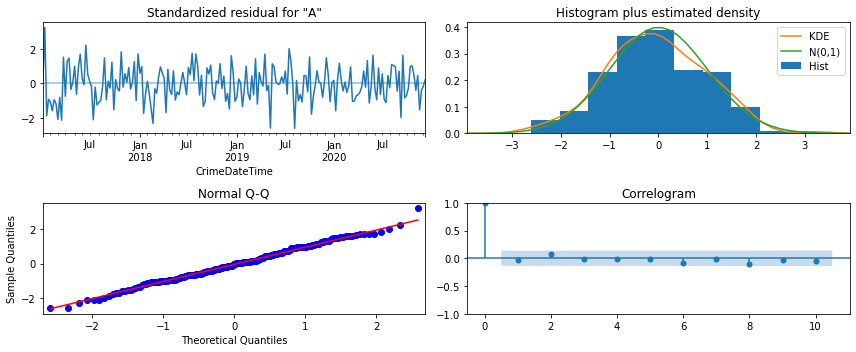

In [17]:
## Fit a final model and evaluate
best_model = tsa.SARIMAX(train,order=auto_model.order,
                seasonal_order = auto_model.seasonal_order,
                enforce_invertibility=False).fit()


## Display Summary + Diagnostics
display(best_model.summary())
best_model.plot_diagnostics();
plt.tight_layout()

In [18]:
## Get forecast 
forecast = best_model.get_forecast(steps=len(test))

## save forecasted mean and upper/lower ci as df
forecast_df = forecast.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df

Lower CI  Upper CI  Forecast
2020-12-20 00:00:00+00:00    31.838    75.467    53.653
2020-12-27 00:00:00+00:00    31.301    78.381    54.841
2021-01-03 00:00:00+00:00    29.930    80.226    55.078
2021-01-10 00:00:00+00:00    24.617    77.935    51.276
2021-01-17 00:00:00+00:00    25.802    81.979    53.890
2021-01-24 00:00:00+00:00    26.342    85.241    55.791
2021-01-31 00:00:00+00:00    23.854    85.353    54.603
2021-02-07 00:00:00+00:00    21.893    85.887    53.890
2021-02-14 00:00:00+00:00    20.693    87.088    53.890
2021-02-21 00:00:00+00:00    17.395    86.108    51.752
2021-02-28 00:00:00+00:00    17.462    88.417    52.940
2021-03-07 00:00:00+00:00    18.514    91.642    55.078
2021-03-14 00:00:00+00:00    14.370    89.609    51.989
2021-03-21 00:00:00+00:00    11.205    88.496    49.851
2021-03-28 00:00:00+00:00    10.680    89.971    50.326
2021-04-04 00:00:00+00:00     8.992    90.234    49.613
2021-04-11 00:00:00+00:00     7.327    90.473    48.900
2021-04-18 00:00:00+00:00     8.059    93.068    50.564
2021-04-25 00:00:00+00:00     8.337    95.167    51.752
2021-05-02 00:00:00+00:00     5.781    94.396    50.088
2021-05-09 00:00:00+00:00     7.282    97.647    52.465
2021-05-16 00:00:00+00:00     2.860    94.941    48.900
2021-05-23 00:00:00+00:00     3.443    97.209    50.326

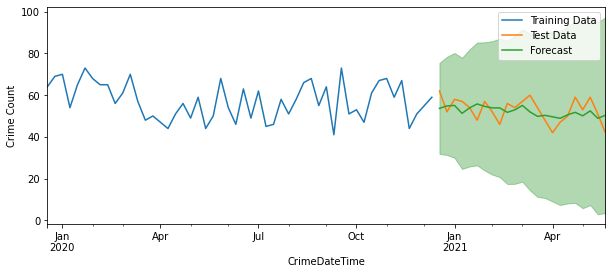

In [19]:
### PLot training data, and forecast (with upper/,lower ci)
last_n_lags=52

fig,ax = plt.subplots(figsize=(10,4))

                      
# Plotting Training and test data
train.iloc[-last_n_lags:].plot(label='Training Data')
test.plot(label='Test Data')

## Plotting Forefcast and CI
forecast_df['Forecast'].plot(ax=ax,label='Forecast')
ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)

ax.set(ylabel='Crime Count')
ax.legend()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          AUTO THEFT   No. Observations:                  230
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -869.807
Date:                             Mon, 14 Jun 2021   AIC                           1745.615
Time:                                     13:18:33   BIC                           1755.916
Sample:                                 01-01-2017   HQIC                          1749.771
                                      - 05-23-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5997      0.048    -12.464      0.000      -0.694      -0.505
ar.S.L52       0.2375      0.071      3.350      0.001       0.099       0.377
sigma2       114.8393     10.628     10.806      0.000      94.009     135.669
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.67   Prob(JB):                         0.90
Heteroskedasticity (H):               0.47   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

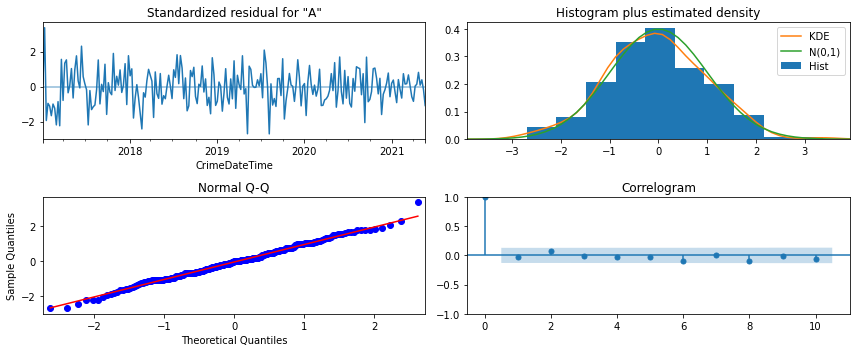

In [20]:
## If happy with the model's test perforamance, retrain on entire ts and forecast into future
## Fit a final model and evaluate
final_model = tsa.SARIMAX(ts,order=auto_model.order,
                seasonal_order = auto_model.seasonal_order,
                enforce_invertibility=False).fit()


## Display Summary + Diagnostics
display(final_model.summary())
final_model.plot_diagnostics();
plt.tight_layout()

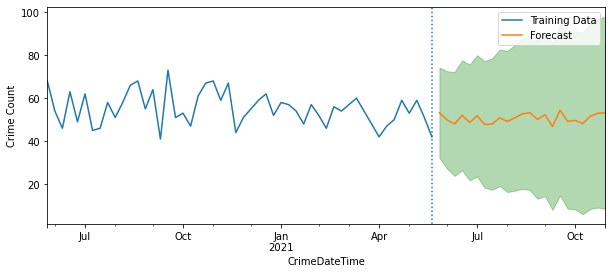

In [21]:
## Get forecast 
forecast = final_model.get_forecast(steps=len(test))

## save forecasted mean and upper/lower ci as df
forecast_df = forecast.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['Forecast'] = forecast.predicted_mean

## Plot
last_n_lags=52

fig,ax = plt.subplots(figsize=(10,4))

                      
# Plotting Training and test data
ts.iloc[-last_n_lags:].plot(label='Training Data')
ax.axvline(ts.index[-1],ls=':')
# test.plot(label='Test Data')

## Plotting Forefcast and CI
forecast_df['Forecast'].plot(ax=ax,label='Forecast')
ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)

ax.set(ylabel='Crime Count')
ax.legend()

## Summary


- Today we discussed the various types of time-series models:
    - AR/MA, ARIMA, SARIMA/SARIMAX.
    - We discussed how ACF/PACF can provide a hint for best params to use for our model. 
    - We also discussed how this info can be harder to see than we'd like. 
    - We introduced performing a gridsearch for our ts models using `pmdarima`

# Bonus: Stocks with Pandas DataReader

In [22]:
# !pip install pandas-datareader
import pandas_datareader as pdr

In [23]:
## List of symbols to grab
symbols = ['FB','AAPL','GOOGL','AMZN','MSFT']

data = {}
for stock in symbols:
    data[stock] = pdr.DataReader(stock,'yahoo','2012','2020')['Adj Close']
dfs = pd.DataFrame(data)
dfs

FB    AAPL     GOOGL     AMZN     MSFT
Date                                                  
2012-01-03     NaN  12.629   333.038   179.03   21.749
2012-01-04     NaN  12.697   334.474   177.51   22.261
2012-01-05     NaN  12.838   329.835   177.61   22.488
2012-01-06     NaN  12.972   325.335   182.61   22.838
2012-01-09     NaN  12.952   311.542   178.56   22.537
...            ...     ...       ...      ...      ...
2019-12-24  205.12  70.235  1344.430  1789.21  155.014
2019-12-26  207.79  71.628  1362.470  1868.77  156.285
2019-12-27  208.10  71.601  1354.640  1869.80  156.571
2019-12-30  204.41  72.026  1339.710  1846.89  155.221
2019-12-31  205.25  72.552  1339.390  1847.84  155.330

[2012 rows x 5 columns]